# Building a Classifier with our labeled Tweets


### In this section, we analyze our tweets using supervised learning methods. I have manully labeled the data to detect which tweets are indicative of flu and which tweets are not.  I employ various NLP methods such as removal of stopwords, stemming, lemmatizing and use of bigrams and trigrams. 

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import preprocessor as p
from nltk.corpus import stopwords

#visualizations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS
import re
import string
import itertools
#from mpl_toolkits.basemap import Basemap

#machine learning
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

In [2]:
df7= pd.read_csv('df_stream7.csv') #good to go
df8=pd.read_csv('df_stream8.csv') #good to go
df9=pd.read_csv('df_stream9.csv') # good to go
df10=pd.read_csv('df_stream10.csv') # good to go
df11=pd.read_csv('df_stream11.csv') # good to go
df13=pd.read_csv('df_stream13.csv') # good to go 
df14=pd.read_csv('df_stream14.csv') # good to go
df16=pd.read_csv('df_stream16.csv') # good to go
df19=pd.read_csv('df_stream19_pos.csv')
df20=pd.read_csv('df_stream20_pos.csv') # good to go
df21=pd.read_csv('df_stream21.csv')
df22=pd.read_csv('df_stream22.csv')
df23=pd.read_csv('df_stream23.csv')

In [3]:
all= pd.concat(([df7,df8,df9,df10,df11,df13,df14,df16,df19,df20, df21, df22,df23]), sort=False)
#saving data
all.to_csv('all.csv')

In [4]:
all.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
all.label.value_counts()

0    3553
1     912
Name: label, dtype: int64

In [6]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4465 entries, 0 to 558
Data columns (total 37 columns):
created_at                   4465 non-null object
id                           4465 non-null float64
id_str                       4465 non-null float64
text                         4464 non-null object
label                        4465 non-null int64
source                       4465 non-null object
truncated                    4465 non-null bool
in_reply_to_status_id        854 non-null float64
in_reply_to_status_id_str    854 non-null float64
in_reply_to_user_id          903 non-null float64
in_reply_to_user_id_str      903 non-null float64
in_reply_to_screen_name      903 non-null object
user                         4463 non-null object
geo                          9 non-null object
coordinates                  9 non-null object
place                        144 non-null object
contributors                 0 non-null float64
retweeted_status             1231 non-null object
quote

In [7]:
all.label.isnull().sum()/len(all)

0.0

In [8]:
#saving combined tweets without cleaning
all.to_csv('all_tweets.csv')

### Let's take a look at the most popular people tweet when they are sick with the flu?

In [9]:
all['Timestamp'] = pd.to_datetime(all['created_at'], infer_datetime_format = "%d/%m/%Y", utc  = False)

In [10]:
#looking at the hour of Tweets
def givehour(timestamp):
    hour_string = timestamp.hour
    return hour_string
all['hour'] = all['Timestamp'].apply(givehour)
hours = all.groupby('hour')
hourcount = hours['text'].count()
hourdict = hourcount.to_dict()

In [11]:
#looking at the day of Tweets
def giveday(timestamp):
    day_string = timestamp.date
    return day_string
all['date'] = all['Timestamp'].apply(giveday)
days = all.groupby('date')
daycount = days['text'].count()
hourdict = daycount.to_dict()

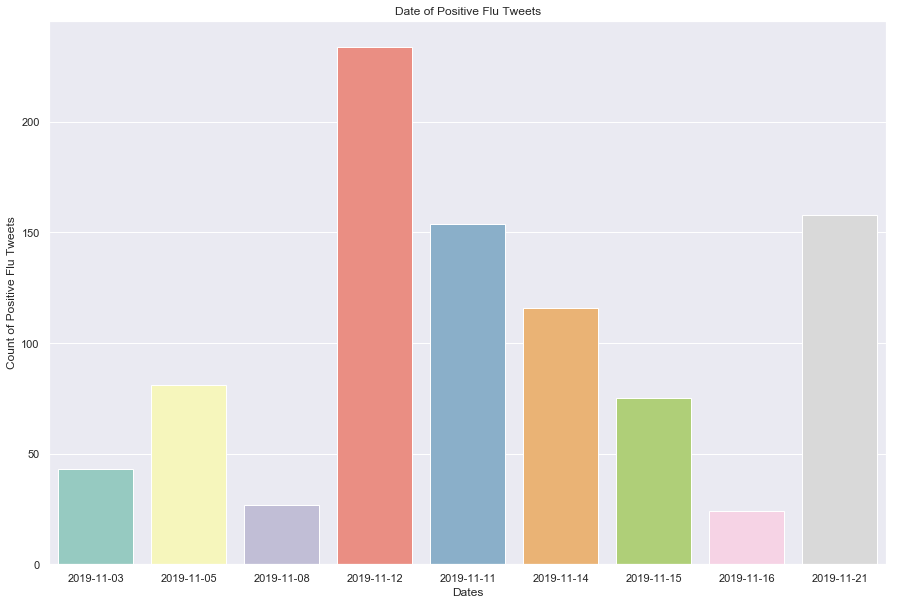

In [12]:
hr= all.loc[all.label==1].date
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
sns.countplot(hr, palette="Set3")
plt.xlabel('Dates')
plt.ylabel('Count of Positive Flu Tweets')
plt.title('Date of Positive Flu Tweets')
plt.show()

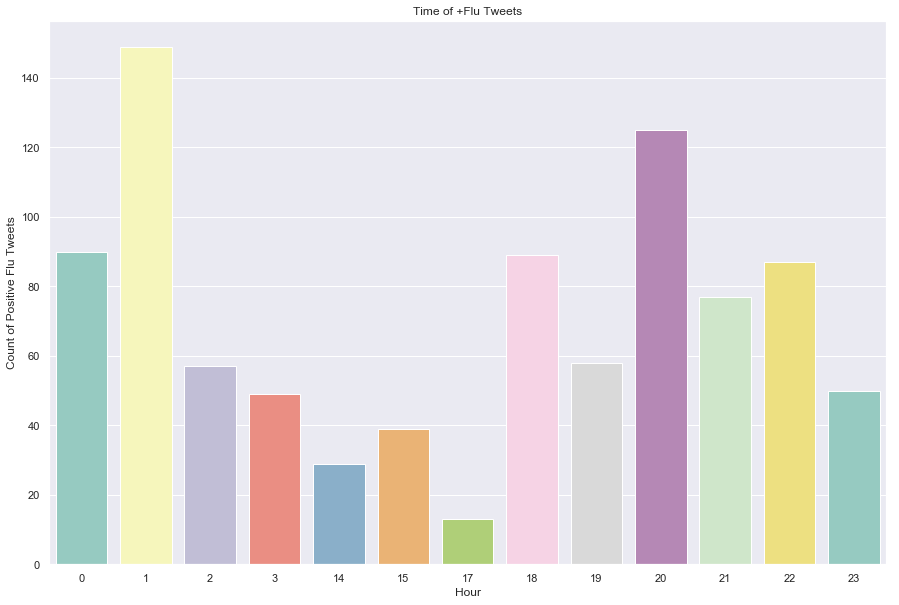

In [93]:
hr= all.loc[all.label==1].hour
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
sns.countplot(hr, palette="Set3")
plt.xlabel('Hour')
plt.ylabel('Count of Positive Flu Tweets')
plt.title('Time of +Flu Tweets')
plt.show()

# Data Cleaning and Feature Engineering

### Tweets have many miscellaneous characters and are prone to having slang and erroneous terms. We will try to clean this data as best as we can before we use it for modeling. 

In [14]:
#Creating dataframe that just focuses on 'Text' and 'Label'. 
new= pd.DataFrame(all[['text', 'label']])

In [15]:
new = new.sample(frac=1).reset_index(drop=True)

In [16]:
new.head(10)

,text,label
0,The free flu jab is also available for people ...,0
1,RT @OUBarstool: “Baker deserved a national cha...,0
2,Got my flu jab today so now I'm in the office ...,0
3,@fireox9 Hummm i've been with a headache for t...,1
4,Throw the whole boyfriend away,0
5,@fancyzealot I got flu and anxiety.,1
6,RT @IllinoisDoctors: Don’t let the flu get you...,0
7,"RT @htTweets: Sanjay Kaushik, assistant conser...",0
8,RT @BramaleaCHC: We’re open for flu shots now!...,0
9,'Flu nearly killed me last winter' - https://t...,0


In [17]:
# While labeling, I've intentionally left some tweets blank to try to achieve a higher positive label.I'm dropping
# the blank tweets here

new.dropna(inplace=True)

In [18]:
print('Values before dropping duplicate tweets')
new.label.value_counts()

Values before dropping duplicate tweets


0    3552
1     912
Name: label, dtype: int64

In [19]:
# because there were so many tweets that are Retweeets or the same tweets over and over again in the feeds,
# I've had to drop it here. 
new.drop_duplicates(inplace=True)

In [20]:
print('Values after dropping duplicate tweets')
new.label.value_counts()

Values after dropping duplicate tweets


0    3427
1     896
Name: label, dtype: int64

### Creating functions to clean tweets and add new columns as we clean and process.

In [21]:
#removing URLs and string beginning with @ 
def remove_mentionsURLs(text):
    tweet_out= re.sub(r'@[A-Za-z0-9]+', '', text)
    tweet_out=re.sub(r'http\S+', '', tweet_out)
    tweet_out= re.sub(r'RT @[\w_]+:', '', tweet_out)
    return tweet_out

new['text_noURLs'] = new['text'].apply(lambda x: remove_mentionsURLs(x))

In [22]:
#removing punctuations from the text
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

new['text_punct'] = new['text_noURLs'].apply(lambda x: remove_punct(x))

In [23]:
# remove words with 2 or less characters
def remove_RT(text):
    text= re.sub(r'\b\w{1,2}\b', '', text)
    return text

new['text_removeRT'] = new['text_punct'].apply(lambda x: remove_RT(x))

In [24]:
#tokenzing into words 
def tokenization(text):
    text = re.split('\W+', text)
    return text

new['tokenized'] = new['text_removeRT'].apply(lambda x: tokenization(x.lower()))

In [25]:
#removing stop words
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
new['nonstop'] = new['tokenized'].apply(lambda x: remove_stopwords(x))

In [26]:
# lemmatizing
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

new['Tweet_lemmatized'] = new['nonstop'].apply(lambda x: lemmatizer(x))

In [27]:
#stemming
from nltk.stem import PorterStemmer 
port_stemmer= nltk.PorterStemmer()

def stemming(text):
    #stripped = [word.lower() for word in text if word.lower() not in stopwords]
    out_text= [port_stemmer.stem(word) for word in text]
    return out_text

new['stemmed']= new['nonstop'].apply(lambda x: stemming(x))

In [28]:
#Let's check to see how many unique words in lemmatized and stemmed words

word_count_lemma= list(itertools.chain.from_iterable(new['Tweet_lemmatized']))
word_count_stem= list(itertools.chain.from_iterable(new['stemmed']))

print('Unique words in lemmatized text:' +str(len(set(word_count_lemma))));
print('Unique words in stemmed text:' +str(len(set(word_count_stem))));

Unique words in lemmatized text:6937
Unique words in stemmed text:5975


In [29]:
# this removes less frequent words, leaving ONLY frequent words
flat_list= list(itertools.chain.from_iterable(new['stemmed']))
fd= nltk.FreqDist(flat_list)

keep_words= list(filter(lambda x: 2500>x[1]>3, fd.items()))
keep_words_list= [item[0] for item in keep_words]

def remove_lessfreq(tokanized_tweets):
    text_out= [word for word in tokanized_tweets if word in keep_words_list]
    return text_out
#removing less frequent words that are stemmed
new['remove_less_freq']= new['stemmed'].apply(lambda x: remove_lessfreq(x))
#removing less frequent words that are stemmed
new['remove_less_freq_lemma']= new['Tweet_lemmatized'].apply(lambda x: remove_lessfreq(x))

In [30]:
print(keep_words_list[0:10])

['free', 'jab', 'also', 'avail', 'peopl', 'certain', 'medic', 'condit', 'includ', 'learn']


In [31]:
# joining words back for modeling
def join_tokens(tokens):
    documents= " ".join([word for word in tokens if not word.isdigit()])
    return documents
#this one is from stemmed words with common words
new['document']= new['remove_less_freq'].apply(lambda x: join_tokens(x))

In [32]:
def join_tokens(tokens):
    documents= " ".join([word for word in tokens if not word.isdigit()])
    return documents
#this one is lemma words 
new['document_lemma']= new['Tweet_lemmatized'].apply(lambda x: join_tokens(x))

In [33]:
def join_tokens(tokens):
    documents= " ".join([word for word in tokens if not word.isdigit()])
    return documents

new['document_stemmed']= new['stemmed'].apply(lambda x: join_tokens(x))

### Comparing what stemmed words looks like without removing less frequent words, 

In [34]:
#comparing what stemmed words looks like without removing less frequent words
print(new['document_stemmed'])             

0       free flu jab also avail peopl certain medic co...
1        baker deserv nation championship anyon planet...
2           got flu jab today offic tri work fluarm like 
3        hummm ive headach last two week straight toge...
4                              throw whole boyfriend away
                              ...                        
4460     bambam said youll never catch slip fashion ki...
4461          outstand support bmore healthi bmore involv
4462     past hr usa horrif lost peopl mass shoot aver...
4463     famili richmondbc roll sleev host flu clinic ...
4464          flu made everi time poop feel like pee help
Name: document_stemmed, Length: 4323, dtype: object


In [35]:
#stemmed words removing less 
print(new['document']) 

0       free jab also avail peopl certain medic condit...
1                              deserv nation anyon averag
2                       got jab today offic tri work like
3         ive headach last two week straight togeth today
4                              throw whole boyfriend away
                              ...                        
4460       said youll never catch slip fashion year round
4461                   support bmore healthi bmore involv
4462    past hr lost peopl shoot averag across hr also...
4463     famili roll sleev host clinic call ahead appoint
4464                       made everi time feel like help
Name: document, Length: 4323, dtype: object


In [36]:
list_unique= set(list(itertools.chain.from_iterable(new['remove_less_freq'])))
print (list_unique)

{'trump', 'machin', 'fact', 'vaccineswork', 'limit', 'spell', 'media', 'global', 'forecast', 'immigr', 'district', 'suppos', 'latest', 'find', 'alreadi', 'citi', 'women', 'ward', 'agre', 'wale', 'ignor', 'ceo', 'schedul', 'peac', 'honor', 'poor', 'season', 'highest', 'condit', 'ppl', 'size', 'canadian', 'anyth', 'news', 'measl', 'circl', 'stream', 'question', 'fri', 'strong', 'stupid', 'offic', 'epidem', 'üòí', 'exactli', 'wanna', 'pregnant', 'record', 'disabl', 'admin', 'wit', 'ach', 'fluvaccin', 'huge', 'min', 'sure', 'lay', 'father', 'treatment', 'tast', 'back', 'afford', 'nope', 'symptom', 'viral', 'none', 'cri', 'daughter', 'äôall', 'travel', 'celebr', 'busi', 'accord', 'wors', 'movi', 'hold', 'your', 'continu', 'obvious', 'he', 'read', 'explain', 'educ', 'get', 'turn', 'seen', 'getvaccin', 'public', 'diseas', 'mention', 'older', 'thi', 'may', 'like', 'disord', 'product', 'urgent', 'andor', 'thank', 'would', 'plu', 'bed', 'pull', 'nation', 'fail', 'central', 'expos', 'spread', 'pa

In [37]:
new.to_csv('data/cleaned_tweets.csv')

In [94]:
new.head()

,text,label,text_noURLs,text_punct,text_removeRT,tokenized,nonstop,Tweet_lemmatized,stemmed,remove_less_freq,remove_less_freq_lemma,document,document_lemma,document_stemmed
0,The free flu jab is also available for people ...,0,The free flu jab is also available for people ...,The free flu jab is also available for people ...,The free flu jab also available for people wi...,"[the, free, flu, jab, also, available, for, pe...","[free, flu, jab, also, available, people, cert...","[free, flu, jab, also, available, people, cert...","[free, flu, jab, also, avail, peopl, certain, ...","[free, jab, also, avail, peopl, certain, medic...","[free, jab, also, certain]",free jab also avail peopl certain medic condit...,free flu jab also available people certain med...,free flu jab also avail peopl certain medic co...
1,RT @OUBarstool: “Baker deserved a national cha...,0,RT : “Baker deserved a national championship m...,RT “Baker deserved a national championship mo...,“Baker deserved national championship more ...,"[, baker, deserved, national, championship, mo...","[, baker, deserved, national, championship, an...","[, baker, deserved, national, championship, an...","[, baker, deserv, nation, championship, anyon,...","[deserv, nation, anyon, averag]",[],deserv nation anyon averag,baker deserved national championship anyone p...,baker deserv nation championship anyon planet...
2,Got my flu jab today so now I'm in the office ...,0,Got my flu jab today so now I'm in the office ...,Got my flu jab today so now Im in the office t...,Got flu jab today now the office trying ...,"[got, flu, jab, today, now, the, office, tryin...","[got, flu, jab, today, office, trying, work, f...","[got, flu, jab, today, office, trying, work, f...","[got, flu, jab, today, offic, tri, work, fluar...","[got, jab, today, offic, tri, work, like]","[got, jab, today, work, like]",got jab today offic tri work like,got flu jab today office trying work fluarm like,got flu jab today offic tri work fluarm like
3,@fireox9 Hummm i've been with a headache for t...,1,Hummm i've been with a headache for the last ...,Hummm ive been with a headache for the last t...,Hummm ive been with headache for the last tw...,"[, hummm, ive, been, with, headache, for, the,...","[, hummm, ive, headache, last, two, weeks, str...","[, hummm, ive, headache, last, two, week, stra...","[, hummm, ive, headach, last, two, week, strai...","[ive, headach, last, two, week, straight, toge...","[ive, last, two, week, straight, today]",ive headach last two week straight togeth today,hummm ive headache last two week straight tog...,hummm ive headach last two week straight toge...
4,Throw the whole boyfriend away,0,Throw the whole boyfriend away,Throw the whole boyfriend away,Throw the whole boyfriend away,"[throw, the, whole, boyfriend, away]","[throw, whole, boyfriend, away]","[throw, whole, boyfriend, away]","[throw, whole, boyfriend, away]","[throw, whole, boyfriend, away]","[throw, whole, boyfriend, away]",throw whole boyfriend away,throw whole boyfriend away,throw whole boyfriend away


# I want to visualize the top 20 ngrams for the tweets we've collected. N-grams using the CountVectorizer helps us create bigrams and trigrams. A bigram makes a prediction for a word based on the one before, and a trigram makes a prediction for the word based on the two words before tha

flu 3351
shot 873
got 422
like 306
sick 260
cold 258
getting 231
day 216
year 212
season 210
vaccine 204
time 178
today 175
people 169
week 155
know 144
feel 139
amp 136
work 120
think 115


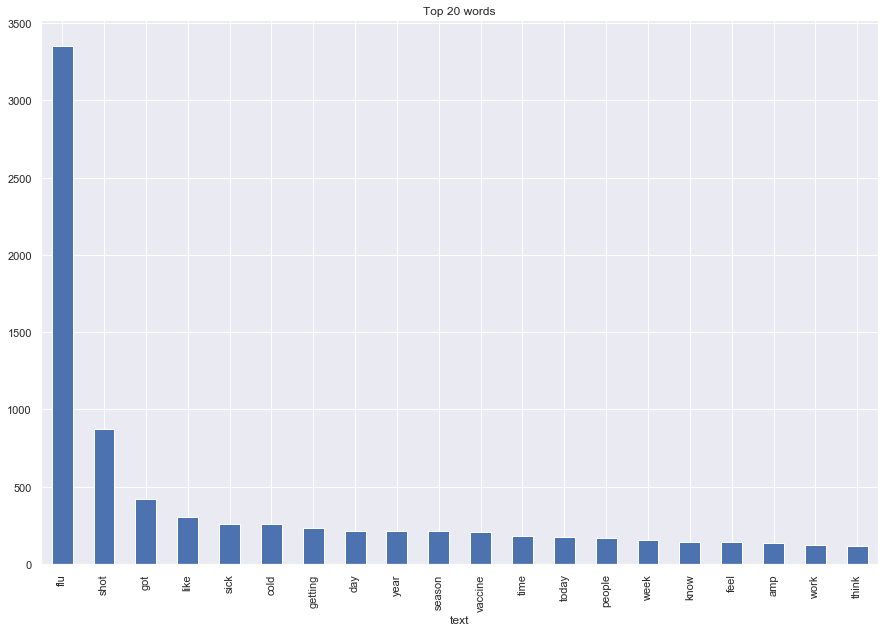

In [90]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(new['document_lemma'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
plt.figure(figsize=(15,10))
df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words')
plt.show()

flu shot 819
got flu 242
flu season 172
getting flu 145
flu vaccine 124
cold flu 100
stomach flu 68
flu jab 65
feel like 55
like flu 42
free flu 39
amp flu 35
sick flu 34
shot today 32
swine flu 31
flu like 31
flu game 29
cold amp 26
year flu 25
man flu 25


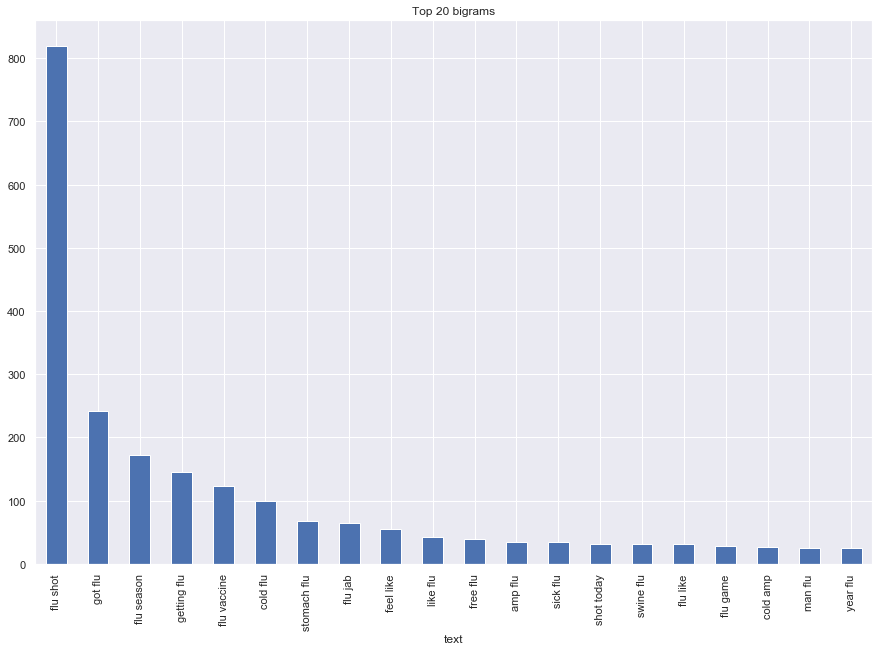

In [91]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(new['document_lemma'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
plt.figure(figsize=(15,10))
df3.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams')
plt.show()

got flu shot 122
getting flu shot 79
flu shot today 32
cold flu season 26
cold amp flu 26
flu shot year 20
free flu shot 17
flu shot flu 16
gotten flu shot 13
flu shot clinic 13
flu nearly killed 12
nearly killed winter 12
flu shot protect 12
flu shot got 11
flu like symptom 11
fried chicken flu 11
feel like flu 11
border patrol refusing 10
patrol refusing let 10
refusing let doctor 10


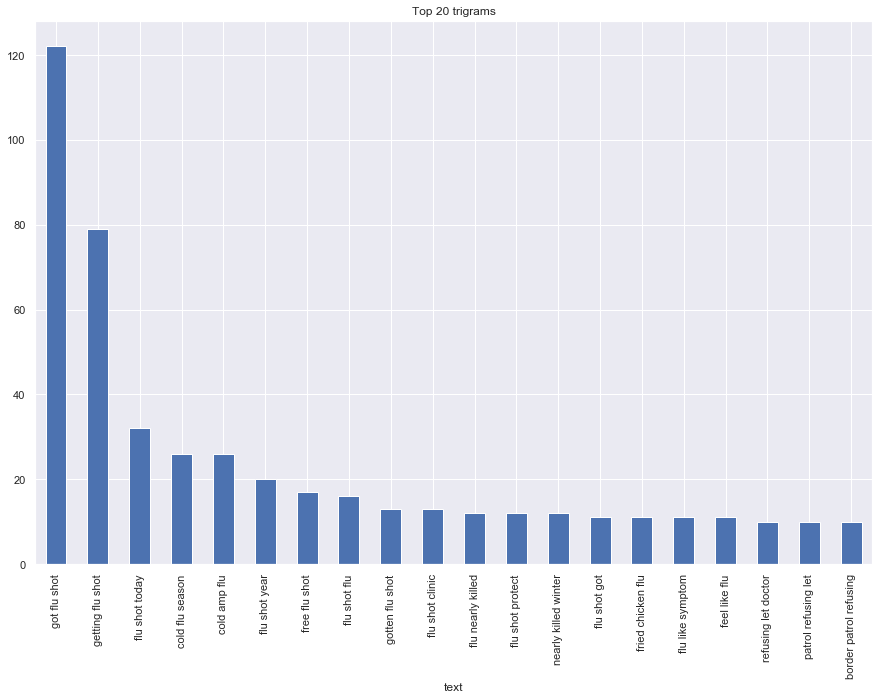

In [92]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(new['document_lemma'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
plt.figure(figsize=(15,10))
df4.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams')
plt.show()

# Defining our bag of words

### Using bag of words with our unique list of words and trying out lemmatized ,stemmed documents. Let's see which ones will get better scores. 

In [41]:
from sklearn.feature_extraction import text
#extended punctuation list
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
#stopwords_en = stopwords.words('english')

#create a bag of words using CountVectorizer.
vectorizer = CountVectorizer(vocabulary=list_unique,#max_features=2000,
                                min_df=10, 
                             stop_words=stop_words,
                             #tokenizer='callable',
                             ngram_range=(1, 1),
                            strip_accents='ascii')
X = vectorizer.fit_transform(new['document'])
#extracting features 
columns = list(vectorizer.get_feature_names())
print('There are {} features'.format(len(columns)))
print(columns[0:20])

# Convert bag of words to a dataframe
count_vectordf = pd.DataFrame(X.toarray(), columns=columns)
count_vectordf.head()

There are 1395 features
['abl', 'absolut', 'accept', 'accord', 'account', 'ach', 'across', 'act', 'action', 'activ', 'actual', 'acut', 'ad', 'add', 'adem', 'admin', 'administ', 'administr', 'admit', 'adult']


,abl,absolut,accept,accord,account,ach,across,act,action,activ,...,üíø,üòä,üòå,üòç,üòé,üòí,üòî,üòû,üôå,üôé
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting

In [42]:
X_train, X_test, y_train, y_test = train_test_split(count_vectordf, new['label'], test_size=0.20, random_state=42)

In [43]:
#sm = SMOTE(random_state=12, ratio = 1.0)
#from imblearn.over_sampling import SMOTE
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [44]:
#from sklearn.utils import resample
#df_majority= new[new.label==0]
#df_minority=new[new.label==1]

#Downsampling majority
#df_majority_downsample= resample(df_majority,replace=False,n_samples=903
 #                                , random_state=0)

#df_downsample= pd.concat([df_majority_downsample, df_minority])

#df_downsample.label.value_counts()

# Logistic Regression with BOW



In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
logreg_train = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.94      0.69      0.79       680
           1       0.42      0.83      0.56       185

    accuracy                           0.72       865
   macro avg       0.68      0.76      0.68       865
weighted avg       0.83      0.72      0.74       865

AUC score: 0.7595985691573927
Classification accuracy is:  0.7179190751445087


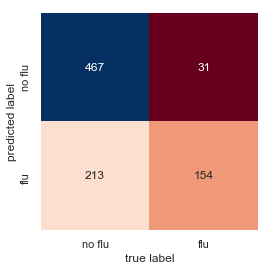

In [46]:
y_pred = logreg_train.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))


sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


## Random Forest with BOW

In [47]:
n_estimators = [100]
max_depth = [5, 8]
min_samples_split = [2, 3]
min_samples_leaf = [1, 2] 
rfc = RandomForestClassifier(class_weight='balanced')
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=5)
random_forest = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.95      0.56      0.71       680
           1       0.36      0.89      0.51       185

    accuracy                           0.63       865
   macro avg       0.65      0.73      0.61       865
weighted avg       0.82      0.63      0.67       865

AUC score: 0.7255961844197139
Classification accuracy is:  0.6335260115606937


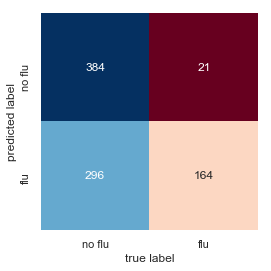

In [48]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 1066 (0.0797) shot
2. feature 1265 (0.0327) vaccin
3. feature 1037 (0.0201) season
4. feature 443 (0.0169) feel
5. feature 298 (0.0152) day
6. feature 876 (0.0139) peopl
7. feature 533 (0.0127) got
8. feature 1304 (0.0106) week
9. feature 1072 (0.0105) sick
10. feature 1132 (0.0079) stomach
11. feature 698 (0.0075) like
12. feature 1149 (0.0067) suck
13. feature 1198 (0.0066) think
14. feature 643 (0.0064) jab
15. feature 117 (0.0058) bed
16. feature 1355 (0.0058) year
17. feature 556 (0.0057) hate
18. feature 1211 (0.0055) time
19. feature 970 (0.0051) realli
20. feature 492 (0.0050) free


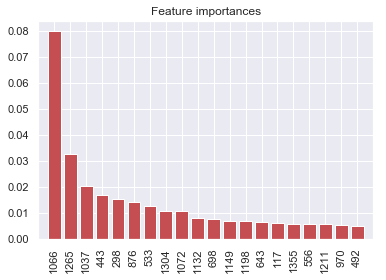

In [49]:
#have to fit without Gridsearch to get feature importances
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = vectorizer.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()

# Naive Bayes with BOW

In [50]:
naive_bayes = MultinomialNB()
param_grid = {'alpha':[1, 1e-1, 1e-2] }

grid = GridSearchCV(naive_bayes, param_grid, scoring='roc_auc', cv=5)
nb = grid.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.87      0.88      0.87       680
           1       0.54      0.50      0.52       185

    accuracy                           0.80       865
   macro avg       0.70      0.69      0.70       865
weighted avg       0.80      0.80      0.80       865

AUC score: 0.6925278219395866
Classification accuracy is:  0.8011560693641618


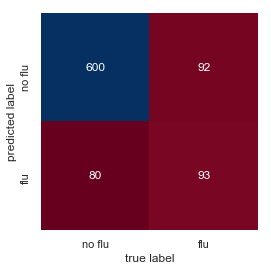

In [51]:
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


## Not bad for our a small dataset and imbalanced classes. But there's more things to try. This time we'll take our lemmatized words and see if it improves scores

In [52]:
cv=CountVectorizer(strip_accents='ascii')

count_vector=cv.fit_transform(new['document_lemma'])
count_vectordf= pd.DataFrame(count_vector.toarray())
count_vectordf.columns= cv.get_feature_names()
X_train, X_test, y_train, y_test = train_test_split(count_vectordf, new['label'], test_size=0.20, random_state=42)

## Random Forest with BOW Lemma

In [53]:
n_estimators = [100, 200]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 
rfc = RandomForestClassifier(class_weight='balanced')
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=5)
random_forest = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       680
           1       0.50      0.89      0.64       185

    accuracy                           0.78       865
   macro avg       0.73      0.82      0.74       865
weighted avg       0.86      0.78      0.80       865

AUC score: 0.82241653418124
Classification accuracy is:  0.7826589595375723


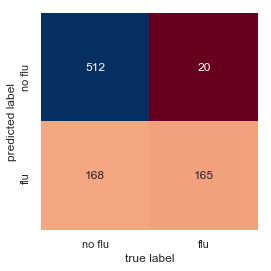

In [54]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 2241 (0.1160) flu
2. feature 5388 (0.0723) shot
3. feature 5263 (0.0160) season
4. feature 6437 (0.0157) vaccine
5. feature 4413 (0.0086) people
6. feature 2470 (0.0079) get
7. feature 5730 (0.0077) stomach
8. feature 2136 (0.0074) feel
9. feature 1467 (0.0067) day
10. feature 2543 (0.0066) got
11. feature 3153 (0.0065) jab
12. feature 5416 (0.0054) sick
13. feature 2473 (0.0051) getting
14. feature 1104 (0.0051) cold
15. feature 3460 (0.0050) like
16. feature 993 (0.0048) child
17. feature 1108 (0.0047) coldflu
18. feature 3149 (0.0043) ive
19. feature 260 (0.0040) antibiotic
20. feature 6613 (0.0040) week


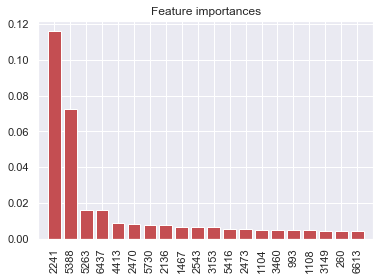

In [55]:
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = cv.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()

## Logistic Regression with BOW Lemma

In [56]:
logreg = LogisticRegression(class_weight='balanced', solver= 'liblinear', random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
logreg_train = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       680
           1       0.57      0.85      0.68       185

    accuracy                           0.83       865
   macro avg       0.76      0.84      0.78       865
weighted avg       0.87      0.83      0.84       865

AUC score: 0.8375596184419714
Classification accuracy is:  0.8312138728323699


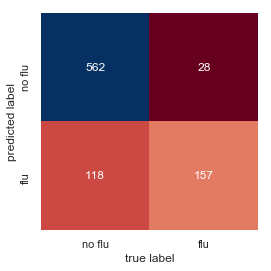

In [57]:
y_pred = logreg_train.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))


sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


# Naive Bayes with BOW Lemma

In [58]:
naive_bayes = MultinomialNB()
param_grid = {'alpha':[1, 1e-1, 1e-2] }

grid = GridSearchCV(naive_bayes, param_grid, scoring='roc_auc', cv=5)
nb = grid.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.92      0.77      0.84       680
           1       0.46      0.74      0.57       185

    accuracy                           0.76       865
   macro avg       0.69      0.75      0.70       865
weighted avg       0.82      0.76      0.78       865

AUC score: 0.7540937996820349
Classification accuracy is:  0.761849710982659


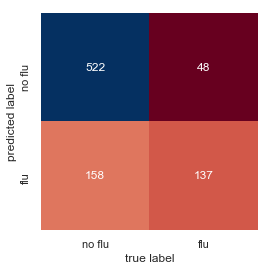

In [59]:
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


# Using TF-IDF

In [60]:
# Split original into train and test, used to look at text later
from sklearn.feature_extraction import text
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", 'pron']
stop_words = text.ENGLISH_STOP_WORDS.union(punc)


X_train, X_test, y_train, y_test = train_test_split(new['document_lemma'], 
                                                    new['label'], 
                                                    test_size=0.25, 
                                                    random_state=0)

#creating our Tf_idf vectorizer
vectorizer_tfidf = TfidfVectorizer(#vocabulary= list_unique,
    max_features= 1000, # drop words that occur in more than this % of paragraphs
                             #min_df=1# only use words that appear at least 10 times
                             stop_words=stop_words, 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True ,#Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            strip_accents= 'ascii')


# Fit and transform training data set, only transform test
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print("Number of features: %d" % X_train_tfidf.get_shape()[1])

Number of features: 1000


## Random Forest Tf-IDF

In [61]:
n_estimators = [100, 200]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 
rfc = RandomForestClassifier(class_weight='balanced')
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=5)
random_forest = grid.fit(X_train_tfidf, y_train)

              precision    recall  f1-score   support

           0       0.96      0.77      0.86       841
           1       0.53      0.90      0.66       240

    accuracy                           0.80      1081
   macro avg       0.75      0.83      0.76      1081
weighted avg       0.87      0.80      0.81      1081

AUC score: 0.8346611177170036
Classification accuracy is:  0.7983348751156337


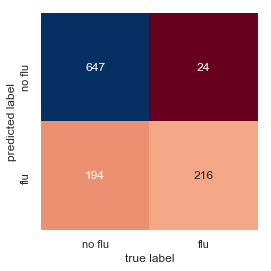

In [62]:
y_pred = random_forest.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 307 (0.1618) flu
2. feature 760 (0.1004) shot
3. feature 741 (0.0234) season
4. feature 923 (0.0199) vaccine
5. feature 352 (0.0195) got
6. feature 197 (0.0183) day
7. feature 293 (0.0130) feel
8. feature 150 (0.0114) cold
9. feature 806 (0.0111) stomach
10. feature 151 (0.0110) coldflu
11. feature 71 (0.0109) bed
12. feature 620 (0.0106) people
13. feature 990 (0.0096) year
14. feature 763 (0.0092) sick
15. feature 492 (0.0091) like
16. feature 446 (0.0087) jab
17. feature 857 (0.0073) think
18. feature 955 (0.0072) week
19. feature 445 (0.0068) ive
20. feature 336 (0.0062) game


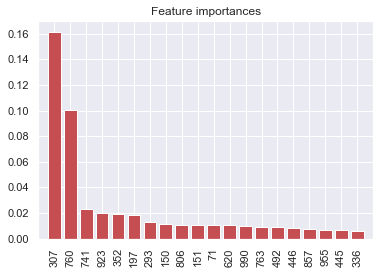

In [63]:
rfc.fit(X_train_tfidf, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = vectorizer_tfidf.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()

## Logistic Regression with TF-IDF

In [64]:
logreg = LogisticRegression(class_weight='balanced', solver= 'liblinear', random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
logreg_train = grid.fit(X_train_tfidf, y_train)

              precision    recall  f1-score   support

           0       0.92      0.84      0.87       841
           1       0.56      0.73      0.63       240

    accuracy                           0.81      1081
   macro avg       0.74      0.78      0.75      1081
weighted avg       0.84      0.81      0.82      1081

AUC score: 0.7825381490289337
Classification accuracy is:  0.8122109158186864


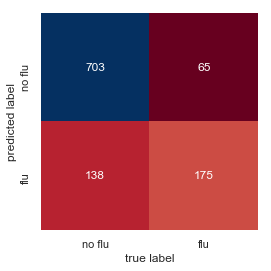

In [65]:
y_pred = logreg_train.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))


sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


## Naive Bayes with TF-IDF

In [66]:
naive_bayes = MultinomialNB()
param_grid = {'alpha':[1, 1e-1, 1e-2] }

grid = GridSearchCV(naive_bayes, param_grid, scoring='roc_auc', cv=5)
nb = grid.fit(X_train_tfidf, y_train)


              precision    recall  f1-score   support

           0       0.82      0.96      0.88       841
           1       0.64      0.27      0.38       240

    accuracy                           0.80      1081
   macro avg       0.73      0.61      0.63      1081
weighted avg       0.78      0.80      0.77      1081

AUC score: 0.6134190447879508
Classification accuracy is:  0.8038852913968547


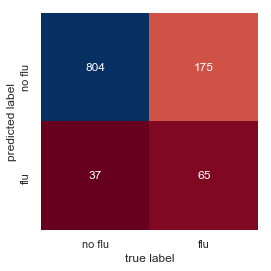

In [67]:
y_pred = nb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

# Bigrams

In [68]:
# Using bigrams 
cv=CountVectorizer(ngram_range=(2, 2))
count_vector= cv.fit_transform(new['document_lemma'])
count_vectordf= pd.DataFrame(count_vector.toarray())
count_vectordf.columns= cv.get_feature_names()

In [69]:
X= count_vectordf
X_train, X_test, y_train, y_test = train_test_split(X, new['label'], test_size=0.20, random_state=42)

## Random Forest with Bigrams

In [70]:
n_estimators = [100, 200]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 
rfc = RandomForestClassifier(class_weight='balanced')
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=5)
random_forest = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       680
           1       0.72      0.40      0.51       185

    accuracy                           0.84       865
   macro avg       0.79      0.68      0.71       865
weighted avg       0.83      0.84      0.82       865

AUC score: 0.6786764705882353
Classification accuracy is:  0.838150289017341


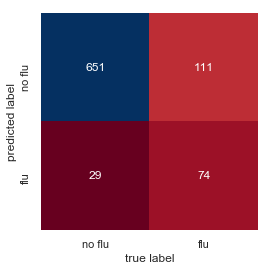

In [71]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 6861 (0.0534) flu shot
2. feature 8279 (0.0170) got flu
3. feature 6841 (0.0143) flu season
4. feature 7012 (0.0112) flu vaccine
5. feature 6924 (0.0078) flu suck
6. feature 7732 (0.0068) get flu
7. feature 6640 (0.0060) flu jab
8. feature 8723 (0.0055) hate flu
9. feature 5943 (0.0053) feel like
10. feature 7469 (0.0051) fuck flu
11. feature 6432 (0.0047) flu day
12. feature 2592 (0.0044) caught flu
13. feature 17140 (0.0043) sick flu
14. feature 14620 (0.0042) pretty sure
15. feature 19103 (0.0040) think flu
16. feature 7868 (0.0037) getting flu
17. feature 2200 (0.0036) bruh flu
18. feature 6643 (0.0036) flu joke
19. feature 3914 (0.0035) damn flu
20. feature 4026 (0.0034) day flu


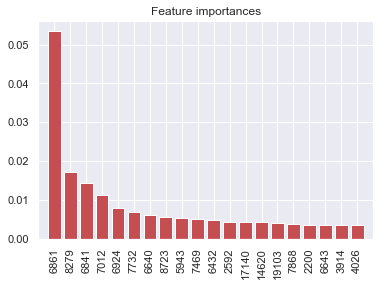

In [72]:
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = cv.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()

## Logistic Regression with Bigrams

In [73]:
logreg = LogisticRegression(class_weight='balanced', solver= 'liblinear', random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
logreg_train = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       680
           1       0.73      0.61      0.66       185

    accuracy                           0.87       865
   macro avg       0.81      0.77      0.79       865
weighted avg       0.86      0.87      0.86       865

AUC score: 0.7718203497615261
Classification accuracy is:  0.8670520231213873


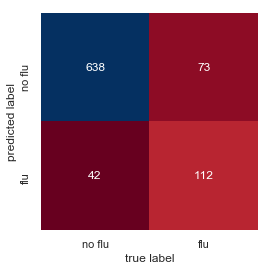

In [74]:
y_pred = logreg_train.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))


sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


## Naive Bayes with Bigrams

In [75]:
naive_bayes = MultinomialNB()
param_grid = {'alpha':[1, 1e-1, 1e-2] }

grid = GridSearchCV(naive_bayes, param_grid, scoring='roc_auc', cv=5)
nb = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.87      0.61      0.72       680
           1       0.32      0.67      0.43       185

    accuracy                           0.63       865
   macro avg       0.60      0.64      0.58       865
weighted avg       0.75      0.63      0.66       865

AUC score: 0.6424880763116059
Classification accuracy is:  0.6265895953757226


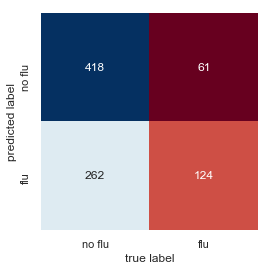

In [76]:
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

# Trigrams

In [77]:
#Trigrams
cv=CountVectorizer(ngram_range=(3, 3))
count_vector= cv.fit_transform(new['document_lemma'])
count_vectordf= pd.DataFrame(count_vector.toarray())
count_vectordf.columns= cv.get_feature_names()
X= count_vectordf
X_train, X_test, y_train, y_test = train_test_split(X, new['label'], test_size=0.20, random_state=42)

## Random Forest with Trigrams

In [78]:
n_estimators = [100, 200]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 
rfc = RandomForestClassifier(class_weight='balanced')
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=5)
random_forest = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.96      0.21      0.34       680
           1       0.25      0.97      0.40       185

    accuracy                           0.37       865
   macro avg       0.60      0.59      0.37       865
weighted avg       0.81      0.37      0.36       865

AUC score: 0.5889308426073132
Classification accuracy is:  0.3722543352601156


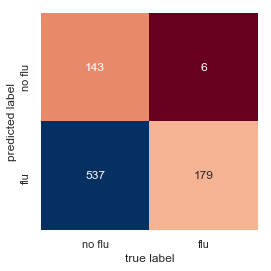

In [79]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 8783 (0.0152) get flu shot
2. feature 9524 (0.0073) got flu shot
3. feature 15865 (0.0056) pretty sure flu
4. feature 9011 (0.0050) getting flu shot
5. feature 3018 (0.0038) cold flu season
6. feature 6854 (0.0032) flu kicking as
7. feature 20444 (0.0032) think catching flu
8. feature 9530 (0.0030) got flu smh
9. feature 20477 (0.0028) think got flu
10. feature 5868 (0.0027) feel like flu
11. feature 14744 (0.0026) omg got flu
12. feature 5879 (0.0026) feel like shit
13. feature 7879 (0.0024) flu two week
14. feature 7621 (0.0024) flu shot today
15. feature 6637 (0.0024) flu fuck day
16. feature 18539 (0.0023) sickening truly flu
17. feature 6799 (0.0023) flu ive got
18. feature 8991 (0.0022) getting flu cold
19. feature 7113 (0.0022) flu really got
20. feature 21987 (0.0022) wait still flu


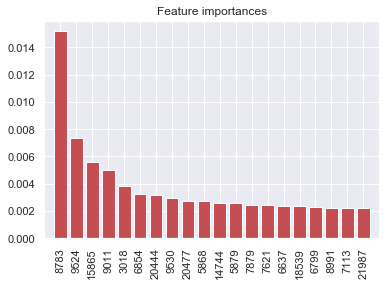

In [80]:
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = cv.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()

## Logistic Regression with Trigrams

In [81]:
logreg = LogisticRegression(class_weight='balanced', solver= 'liblinear', random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
logreg_train = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       680
           1       0.76      0.14      0.23       185

    accuracy                           0.81       865
   macro avg       0.78      0.56      0.56       865
weighted avg       0.80      0.81      0.75       865

AUC score: 0.5616852146263911
Classification accuracy is:  0.8057803468208092


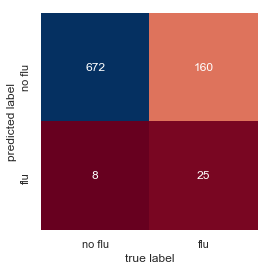

In [82]:
y_pred = logreg_train.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))


sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');


## Naive Bayes with Trigrams

In [83]:
naive_bayes = MultinomialNB()
param_grid = {'alpha':[1, 1e-1, 1e-2] }

grid = GridSearchCV(naive_bayes, param_grid, scoring='roc_auc', cv=5)
nb = grid.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.82      0.48      0.61       680
           1       0.25      0.62      0.35       185

    accuracy                           0.51       865
   macro avg       0.53      0.55      0.48       865
weighted avg       0.70      0.51      0.55       865

AUC score: 0.550516693163752
Classification accuracy is:  0.5098265895953757


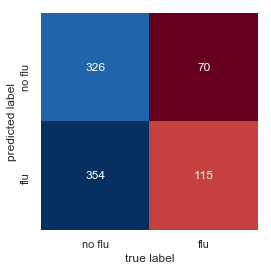

In [84]:
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print("Classification accuracy is: ", (mat[0][0] + mat[1][1]) / np.sum(mat))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');